In [1]:
import cv2
import mediapipe as mp
import numpy as np
import json
import matplotlib.pyplot as plt
import os

In [2]:
mpsolution = mp.solutions.holistic
drawing = mp.solutions.drawing_utils

In [3]:
def Superimpose(image, landmarks):
    drawing.draw_landmarks(image, landmarks.face_landmarks, mpsolution.FACEMESH_CONTOURS, drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1), drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    drawing.draw_landmarks(image, landmarks.pose_landmarks, mpsolution.POSE_CONNECTIONS)
    drawing.draw_landmarks(image, landmarks.left_hand_landmarks, mpsolution.HAND_CONNECTIONS, drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1), drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    drawing.draw_landmarks(image, landmarks.right_hand_landmarks, mpsolution.HAND_CONNECTIONS, drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1), drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))

In [4]:
def BrightnessContrast(img, brightness = 0, contrast = 0):
     
    # getTrackbarPos returns the current
    # position of the specified trackbar.
    # brightness = cv2.getTrackbarPos('Brightness', 'test')
      
    # contrast = cv2.getTrackbarPos('Contrast', 'test')
  
    effect = controller(img, brightness, contrast)
  
    # The function imshow displays an image
    # in the specified window
    return effect

def controller(img, brightness=255, contrast=127):
    brightness = int((brightness - 0) * (255 - (-255)) / (510 - 0) + (-255))
    contrast = int((contrast - 0) * (127 - (-127)) / (254 - 0) + (-127))
  
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            max = 255
        else:
            shadow = 0
            max = 255 + brightness

        al_pha = (max - shadow) / 255
        ga_mma = shadow
  
        # The function addWeighted calculates
        # the weighted sum of two arrays
        cal = cv2.addWeighted(img, al_pha, img, 0, ga_mma)
    else:
        cal = img
  
    if contrast != 0:
        Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        Gamma = 127 * (1 - Alpha)  
        # The function addWeighted calculates
        # the weighted sum of two arrays
        cal = cv2.addWeighted(cal, Alpha, cal, 0, Gamma)
  
    # putText renders the specified text string in the image.
    #cv2.putText(cal, 'B:{},C:{}'.format(brightness, contrast), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
  
    return cal

In [5]:
def detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    result = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return result

In [6]:
def Process(result):
    processed = dict()

    if result.pose_landmarks:
        temp = list(result.pose_landmarks.landmark)[0]
        landmarks = np.array([[(res.x - temp.x), (res.y - temp.y), (res.z - temp.z), res.visibility] for res in result.pose_landmarks.landmark])
    else:
        landmarks = np.zeros(33*4)

    processed["pose"] = landmarks.flatten()

    if result.face_landmarks:
        temp = list(result.face_landmarks.landmark)[0]
        landmarks = np.array([[(res.x - temp.x), (res.y - temp.y), (res.z - temp.z)] for res in result.face_landmarks.landmark])
    else:
        landmarks = np.zeros(468*3)

    processed["face"] = landmarks.flatten()

    if result.right_hand_landmarks:
        temp = list(result.right_hand_landmarks.landmark)[0]
        landmarks = np.array([[(res.x - temp.x), (res.y - temp.y), (res.z - temp.z)] for res in result.right_hand_landmarks.landmark])
    else:
        landmarks = np.zeros(21*3)

    processed["right_hand"] = landmarks.flatten()

    if result.left_hand_landmarks:
        temp = list(result.left_hand_landmarks.landmark)[0]
        landmarks = np.array([[(res.x - temp.x), (res.y - temp.y), (res.z - temp.z)] for res in result.left_hand_landmarks.landmark])
    else:
        landmarks = np.zeros(21*3)

    processed["left_hand"] = landmarks.flatten()

    #return processed
    return np.concatenate([processed["pose"], processed["face"], processed["left_hand"], processed["right_hand"]])

In [7]:
def run(path, save, time):
    count = 0
    video = cv2.VideoCapture(path)
    # cv2.namedWindow('test')
    # cv2.createTrackbar('Brightness', 'test', 255, 2 * 255, BrightnessContrast) 
    # cv2.createTrackbar('Contrast', 'test', 127, 2 * 127, BrightnessContrast)
    
    with mpsolution.Holistic(min_detection_confidence = 0.5, min_tracking_confidence=0.5) as model:
        while video.isOpened():
            ret, frame = video.read()
            if not ret:
                print(path)
                break
        
            result1 = detection(frame, model)
            effect = BrightnessContrast(frame, 357, 209)
            result2 = detection(effect, model)

            Superimpose(frame, result1)
            Superimpose(effect, result2)
        
            cv2.imshow("OnlyFans!!", frame)
            cv2.imshow("effect", effect)
            final = Process(result1)
            np.save(save + "/" + str(count), final)
            count += 1

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
    
        video.release()
        cv2.destroyAllWindows()
        return count

video = cv2.VideoCapture(0)
# cv2.namedWindow('test')
# cv2.createTrackbar('Brightness', 'test', 255, 2 * 255, BrightnessContrast) 
# cv2.createTrackbar('Contrast', 'test', 127, 2 * 127, BrightnessContrast)
    
with mpsolution.Holistic(min_detection_confidence = 0.5, min_tracking_confidence=0.5) as model:
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        
        result1 = detection(frame, model)
        effect = BrightnessContrast(frame, 357, 209)
        result2 = detection(effect, model)

        Superimpose(frame, result1)
        Superimpose(effect, result2)
        
        cv2.imshow("OnlyFans!!", frame)
        cv2.imshow("effect", effect)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    video.release()
    cv2.destroyAllWindows()

In [115]:
with open("missing.txt") as f:
    missing = f.readlines()
    missing = [temp.rstrip("\n") for temp in missing]
    
with open("WLASL_v0.3.json") as f:
    temp = json.load(f)
    data = dict()
    count = 0
    for i in range(len(temp)):
        temp2 = temp[i]["instances"].copy()
        for x in temp[i]["instances"]:
            if missing.count(x["video_id"]) > 0:
                temp2.remove(x)
                count += 1
        data[temp[i]["gloss"]] = [(temp3["video_id"], temp3["fps"], temp3["frame_start"], temp3["frame_end"]) for temp3 in temp2]


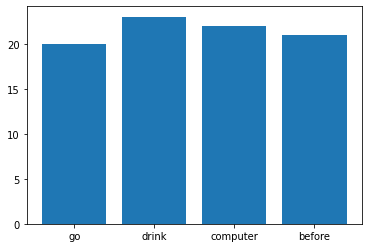

In [116]:
data.keys()
actions = {temp : data[temp] for temp in ["go", "drink", "computer", "before"]}
plt.bar(list(actions.keys()), list(len(temp) for temp in actions.values()), align='center')
plt.xticks(range(len(actions)), list(actions.keys()))

plt.show()


In [118]:
for action in actions:
    os.mkdir("videos/%s"%action)
    for instance in actions[action]:
        os.mkdir("videos/%s/%s"%(action, instance[0]))
        time = int(1000/instance[1])
        run("C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/%s.mp4"%instance[0], "videos/%s/%s"%(action, instance[0]), time)
    

C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/24857.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/69345.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/24955.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/24956.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/24941.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/24960.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/24961.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/24962.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/24965.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/24969.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/24970.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/24971.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/65824.mp4
C:/Users/kev

{'book': ['69241',
  '68011',
  '68012',
  '70212',
  '70266',
  '07086',
  '07069',
  '07089',
  '07091',
  '07093',
  '07068',
  '07095',
  '07097',
  '07070',
  '07099',
  '07072',
  '67424',
  '07074',
  '07075',
  '07076',
  '07078',
  '07080',
  '07082',
  '07084'],
 'drink': ['69302',
  '70173',
  '68042',
  '68041',
  '17725',
  '17727',
  '17728',
  '17710',
  '17729',
  '17730',
  '17731',
  '17733',
  '65540',
  '17734',
  '17711',
  '17712',
  '17713',
  '17715',
  '17717',
  '17709',
  '17719',
  '17720',
  '17721',
  '17722',
  '17723',
  '17724'],
 'computer': ['12306',
  '68028',
  '12328',
  '12329',
  '12330',
  '12312',
  '12331',
  '12332',
  '12333',
  '12335',
  '12311',
  '12338',
  '12313',
  '12314',
  '12315',
  '12316',
  '12317',
  '12318',
  '12319',
  '12320',
  '12321',
  '12323',
  '12326',
  '12327'],
 'before': ['05724',
  '70348',
  '68007',
  '05744',
  '05746',
  '05728',
  '05747',
  '05749',
  '05750',
  '05729',
  '05730',
  '05731',
  '05732',
 